# PyHRF: A Python Library for the Analysis of fMRI Data Based on Local Estimation of Hemodynamic Response Function

This Notebook reproduces the results of the manuscript presented at the *15th Python in Science Conference (Scipy 2017)*.

## Libraries and Auxiliary Methods

First of all, we import the libraries and define some auxiliary methods needed throughout this notebook.

In [1]:
from __future__ import print_function, division

import os
import subprocess
import glob
import shutil
from IPython.display import Image, display

# Fix possible unicode problems
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

# Plotting libraries
%matplotlib inline
from matplotlib import gridspec
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map, plot_roi, plot_anat, plot_epi
from nilearn.image import load_img, resample_img, image


def create_directory(path):
    """Create a new directory if it does not exist.
    
    Parameters
    ----------
    path : str
        Path of the new directory.

    Examples
    --------
    >>> create_directory('/home/jariasal/scipy_notebook/data')
        
    """
    try:
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise

## Paths

Moreover, we define some constant paths.

In [2]:
# Openfmri ID of the dataset that we will use and the path where it will be saved
OPENFMRI_ID = '114'  
OPENFMRI_PATH = os.path.abspath('./data')

# Directory where the output of preprocessing will be saved.
PREPROCESS_PATH = os.path.abspath(os.path.join('./output', OPENFMRI_ID,'preprocessing_output'))
create_directory(PREPROCESS_PATH)

# Directory where the temporal files generated by the preprocessing workflow will be saved
WORKING_PREPROCESS_DIR = os.path.join(PREPROCESS_PATH, 'working_dir')
create_directory(WORKING_PREPROCESS_DIR)

# Directory where the output of PyHRF will be saved
PYHRF_OUTPUT = os.path.abspath(os.path.join('./output', OPENFMRI_ID, 'pyhrf_output'))
create_directory(PYHRF_OUTPUT)

# Directory where figures will be saved
FIGURES_OUTPUT = os.path.abspath(os.path.join('./output', OPENFMRI_ID, 'figures'))
create_directory(FIGURES_OUTPUT)

## Getting fMRI BOLD Data

We use the package ``fetchopenfmri`` to download datasets from the site `openfmri` - https://openfmri.org.

In [3]:
def get_from_openfmri(dataset_id, output_path):
    """Download a dataset from openfmri to a specific path.
    
    Parameters
    ----------
    dataset_id : str
        Openfmri ID of the dataset.
    output_path : str
        Path where the dataset will be saved.

    Returns
    -------
    str
        Absolute path of the dataset on the disk.
        
    Examples
    --------
    >>> print(get_from_openfmri('114', '/home/jariasal/scipy_notebook/data'))
    Dataset ds114 already exists
    /home/jariasal/scipy_notebook/data/openfmri/ds000114_R2.0.1
    
    """
    
    create_directory(output_path)
    dataset_path = get_name_dataset(dataset_id, output_path)
    
    if not dataset_path:                              
        print('Fetching {} from www.openfmri.org to {} ...'.format(dataset_id, output_path), end=' ')
        subprocess.call(['fetchopenfmri', dataset_id, output_path])
        dataset_path = get_name_dataset(dataset_id, output_path)
        print('finished')
    else:
        print('Dataset ds{} already exists'.format(dataset_id))
        
    return dataset_path[0]


def get_name_dataset(dataset_id, output_path):
    """Return the dataset filename on the disk after unzipping.
    
    Parameters
    ----------
    dataset_id : str
        Openfmri ID of the dataset.
    output_path : str
        Path where the dataset is saved.

    Returns
    -------
    str
        Absolute path of the dataset on the disk.
        
    Examples
    --------
    >>> print(get_name_dataset('114', '/home/jariasal/scipy_notebook/data'))
    /home/jariasal/scipy_notebook/data/openfmri/ds000114_R2.0.1
    
    """
    
    return glob.glob(os.path.join(output_path, 'openfmri', 'ds*{}_*[!.tgz,!.zip]'.format(dataset_id)))

In [4]:
dataset_path = get_from_openfmri(OPENFMRI_ID, OPENFMRI_PATH)

## fMRI BOLD Preprocessing

We use the library `Nipype` to preprocess fMRI BOLD data. This library provides a Python wrapping for robust tools, such as `SPM` and `FreeSurfer`.

In [5]:
from nipype.algorithms.misc import Gunzip
from nipype.caching import Memory
from nipype.interfaces.freesurfer import MRIConvert
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.spm as spm
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.pipeline.engine import Node, Workflow, MapNode

def setup_spm(spm_version, spm_path):
    """Set SPM for Nipype.
    
    Parameters
    ----------
    spm_version : int
        Version of the installed SPM.
    spm_path : str
        Path where the dataset is saved.
        
    Examples
    --------
    >>> setup_spm(12, '/home/jariasal')
    SPM configured successfully
    
    """
    
    spm_cmd = '{path}/spm{version}/spm{version}/run_spm{version}.sh {path}/spm{version}/mcr/v713/ script'.format(version=spm_version, path=spm_path)
    spm.SPMCommand.set_mlab_paths(matlab_cmd=spm_cmd, use_mcr=True)
    spm_version = spm.SPMCommand().version
    
    if spm_version is None:
        print('SPM executable not found')
        sys.exit()
    else:
        print('SPM configured successfully')
        
        
def get_voxel_dimension(in_file):
    """Return the voxel dimension of a volume.
        
    Parameters
    ----------
    in_file : str or list of str
        Path or a list of paths of volumes.

    Returns
    -------
    list of float
        List representing the voxel dimension (3D).
        
    Examples
    --------
    >>> print(get_voxel_dimension('/home/jariasal/data/T1.nii'))
    [1.0, 1.0, 1.0]
    
    """
    
    import nibabel
    import numpy
    
    volume = in_file[0] if isinstance(in_file, list) else in_file
    f = nibabel.load(volume)
    voxels = numpy.round(f.get_header().get_zooms()[:3]).tolist()
    
    return voxels

def save_workflow(workflow, output_path):
    """Save the figure of the preprocessing pipeline.
        
    Parameters
    ----------
    workflow : nipype.pipeline.engine.workflows.Workflow
        Preprocessing workflow.
    output_path : str
        Path where the figure will be saved.
    
    Returns
    -------
    str
        Path where the pipeline figure was saved.
    """
    workflow.write_graph(graph2use='colored');  # Draw workflow graph
    
    figure_path = os.path.join(workflow.base_dir, workflow.name, "graph.dot.png")    
    shutil.copy (figure_path, os.path.join(output_path, "nipype_workflow.png"))
    
    return figure_path

### SPM Configuration

Before starting the preprocessing workflow, we need to install `SPM`. To do that, please follow the instructions in https://en.wikibooks.org/wiki/SPM/Standalone.

In [6]:
SPM_VERSION = 12
SPM_DIR = os.path.expanduser('~')
setup_spm(SPM_VERSION, SPM_DIR)

### Scanning Parameters

Since our dataset is the `ds000114`, we following the paper "[A test-retest fMRI dataset for motor, language and spatial attention functions](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3641991/)" to define the parameters for the preprocessing of the fMRI data.

In [7]:
# Number of subjects
N_SUBJECTS = 10
SUBJECTS = ['sub-%02d' % i for i in range(1,N_SUBJECTS+1)]

# Acquisition parameters
TR = 2.5
NUM_SLICES = 30
REF_SLICE = 1
SLICE_ORDER = list(range(1, NUM_SLICES+1, 2) + range(2, NUM_SLICES+1, 2))  # interleaved slice order

### Workflow Definition

For the sake of simplicity, we will focus only on the BOLD responses corresponding to motor tasks in the dataset. The proposed preprocessing workflow implies `slice timing`, `realing`, `coregistration` and `normalization` routines. **It is important to note that `PyHRF` receives a non-smoothed image.**

In [8]:
# Caching directory
mem = Memory(WORKING_PREPROCESS_DIR)

# Preprocessing Workflow
workflow = Workflow(name='workflow')
workflow.base_dir = WORKING_PREPROCESS_DIR

# Node to iterate over the list of subjects
info_source = Node(IdentityInterface(fields=['subject_id']), name='info_source_node')
info_source.iterables = [('subject_id', SUBJECTS)]

# Node to select fMRI images: anatomical and functional
templates = {
    'anat': '{subject_id}/ses-test/anat/*T1*.nii.gz',
    'func': '{subject_id}/ses-test/func/*fingerfootlips*.nii.gz'
}   
select_files = Node(SelectFiles(templates, base_directory=dataset_path), name='select_files')

# Node to store the outputs of each pre-processing step.
datasink = Node(DataSink(base_directory=PREPROCESS_PATH), 'datasink')
datasink.inputs.substitutions = [('_subject_id_', ''),('_input_type_', '')]  # simplifying folder names

# Convert functional nii.gz to nii 
gunzip_func = MapNode(Gunzip(), name="gunzip_func", iterfield=['in_file'])

# Convert anatomical nii.gz to nii (gunzip)
gunzip_anat = Node(Gunzip(), name="gunzip_anat")

# Slice timing - correct for slice wise acquisition
spm_slice_timing = mem.cache(spm.SliceTiming)
slice_timing = Node(spm.SliceTiming(num_slices=NUM_SLICES,
                                    time_repetition=TR,
                                    time_acquisition=TR - (TR / NUM_SLICES),
                                    slice_order=SLICE_ORDER,
                                    ref_slice=REF_SLICE),
                    name='slice_timing_node')

# Node to realign
spm_realign = mem.cache(spm.Realign)
realign = Node(spm.Realign(register_to_mean=True,
                           write_which=[0, 1]),  # mean image only
               name='realign_node')

# Node to coregister
spm_coregister = mem.cache(spm.Coregister)
coregister = Node(spm.Coregister(jobtype='estimate'), name='coregister_node')

# Node to normalize anatomical 
spm_normalize = mem.cache(spm.Normalize12)
normalize_anat = Node(spm.Normalize12(), name='normalize_node_anat')

# Node to normalize functional  
normalize_func = Node(spm.Normalize12(jobtype='write'), name='normalize_node_func')

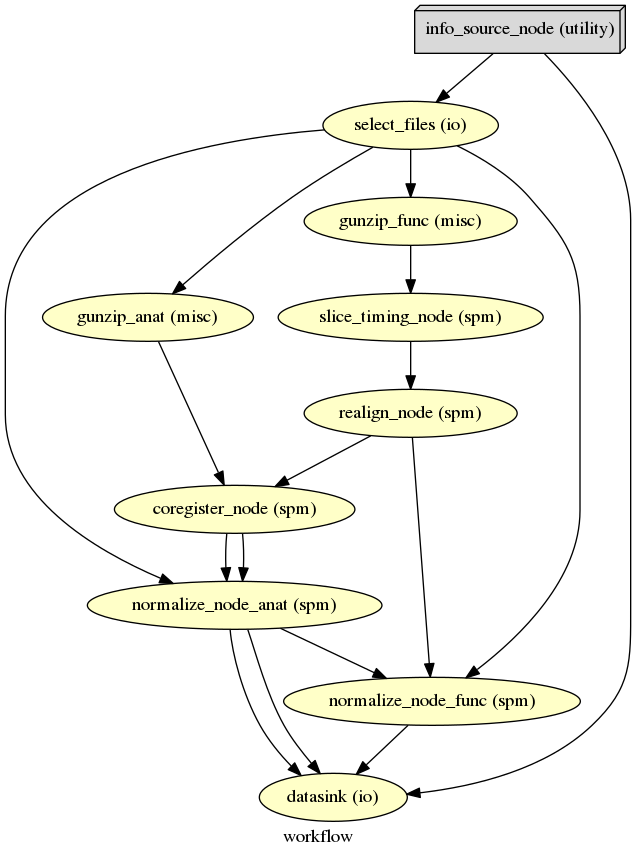

In [9]:
# Connecting nodes to workflow
workflow.connect([
    # Selecting files per subject
    (info_source, select_files, [('subject_id', 'subject_id')]),
    (info_source, datasink, [('subject_id', 'container')]),
    
    # converting images to nii 
    (select_files, gunzip_func, [('func', 'in_file')]),
    (select_files, gunzip_anat, [('anat', 'in_file')]),

    # slice timing
    (gunzip_func, slice_timing, [('out_file', 'in_files')]),
    
    # realignment estimate
    (slice_timing, realign, [('timecorrected_files', 'in_files')]),

    # coregister anatomical to functional
    (realign, coregister, [('mean_image', 'target')]),
    (gunzip_anat, coregister, [('out_file', 'source')]),

    # normalization anatomical
    (select_files, normalize_anat, [(('anat', get_voxel_dimension), 'write_voxel_sizes')]),
    (coregister, normalize_anat, [('coregistered_source', 'image_to_align'),
                                  ('coregistered_source', 'apply_to_files')]),
    (normalize_anat, datasink,
     [('normalized_files', 'normalize_anat.@normalized'),
      ('deformation_field', 'normalize_anat.@deformation')]),

    # normalization functional
    (select_files, normalize_func, [(('func', get_voxel_dimension), 'write_voxel_sizes')]),
    (normalize_anat, normalize_func,[('deformation_field', 'deformation_file')]),
    (realign, normalize_func, [('modified_in_files', 'apply_to_files')]),
    (normalize_func, datasink, [('normalized_files', 'normalize_func')]),

])

# Save and show workflow graph
Image(save_workflow(workflow, FIGURES_OUTPUT))

### Workflow Execution

We execute the preprocessing workflow on multiple processors thanks to the library `joblib`.

In [10]:
# Workflow configuration
workflow.config['execution'] = {'stop_on_first_crash': True,
                                'remove_unnecessary_outputs': False}

# Execute workflow
workflow.run(plugin='MultiProc');

## PyHRF Analysis

Now we analyze the fMRI BOLD data using `PyHRF`. As it is described in the [PyHRF documentation](https://pyhrf.github.io/manual/paradigm.html), the *paradigm* used for the acquisiton must be saved as a `csv` file following a specific format.

In [11]:
import csv
from collections import defaultdict
import nibabel
from nilearn.input_data import NiftiMasker
import numpy as np
import pandas
import pyhrf
from tempfile import NamedTemporaryFile


def convert_to_pyhrf_csv(filename, session, input_fieldnames):
    """Convert a .tsv file in a .csv file with the format accepted by PyHRF.
        
    Parameters
    ----------
    filename : str
        Path of the original tsv file containing the paradigm.
    session : int
        Session number of the acquisition.
    input_fieldnames : list of str
        List containing the columns of the original tsv file.

    Returns
    -------
    str
        Path of the new csv file.
        
    Examples
    --------
    >>> print(convert_to_pyhrf_csv('/home/jariasal/data/paradigm.tsv', 0, ['onset', 'duration', 'weight', 'trial_type']))
    /tmp/tmpM3zBD5
    
    """
    with open(filename, 'r') as readfile, NamedTemporaryFile(delete=False) as writefile:
        event_reader = csv.DictReader(readfile, delimiter='\t')
        
        output_fieldnames = ["session", "condition", "onset", "duration", "amplitude"]
        event_writer = csv.DictWriter(writefile, delimiter=' ', fieldnames=output_fieldnames)
        
        for row in event_reader:
            event_writer.writerow({'session': session, 
                                   'condition': row['trial_type'],
                                   'onset': row['onset'],
                                   'duration': row['duration'],
                                   'amplitude': '1'})
        return writefile.name
    
def get_pyhrf_willard_mask():
    """Return the path of the willard parcellation mask provided by PyHRF.

    Returns
    -------
    str
        Path of the willard parcellation mask.
        
    Examples
    --------
    >>> print(get_willard_mask())
    /home/jariasal/pyhrf/pyhrf/datafiles/stanford_willard_parcellation_3x3x3mm.nii.gz
    
    """
    return pyhrf.get_data_file_name('stanford_willard_parcellation_3x3x3mm.nii.gz')


def get_willard_mask(output_path, func_filename):
    """Create a Willard mask adapted for a BOLD image.
        
    Parameters
    ----------
    output_path : str
        Path where the mask will be saved.
    func_filename : str
        Path of the BOLD image used as reference.

    Returns
    -------
    str
        Path of the generated willard mask.
        
    Examples
    --------
    >>> print(get_willard_mask('/home/jariasal/scipy_notebook/output/114/pyhrf_output', '/home/jariasal/data/bold.nii'))
    /home/jariasal/scipy_notebook/output/114/pyhrf_output/mask_parcellation/willard_2mm.nii
    
    """
    func_img = load_img(func_filename)
    masker = NiftiMasker(mask_strategy='epi')
    masker.fit(func_img)
    
    mask_img = load_img(get_pyhrf_willard_mask())
    resampled_mask = resample_img(mask_img, 
                                  target_affine=masker.mask_img_.affine,
                                  target_shape=masker.mask_img_.get_data().shape,
                                  interpolation='nearest')
        
    output_dir = os.path.join(output_path, 'mask_parcellation')
    create_directory(output_dir)
    resampled_filename = os.path.join(output_dir, 'willard_2mm.nii')
      
    nibabel.save(resampled_mask, resampled_filename)
    
    return resampled_filename

def plot_func_img(filename, output_path):
    """Save and plot a functional image.
        
    Parameters
    ----------
    filename : str
        Path of the BOLD image.
    output_path : str
        Path where the figure will be saved.
    
    """
        
    bold_file = os.path.basename(filename)
    func_img = load_img(filename)

    # Compute the voxel_wise mean of functional images across time.
    mean_img = image.mean_img(func_img)

    # Visualizing mean image (3D)
    plot_epi(mean_img, title=bold_file)
    plt.savefig(os.path.join(output_path, '%s.png' % bold_file));

    
def plot_anatomical(filename, output_path):
    """Save and plot a structural image.
        
    Parameters
    ----------
    filename : str
        Path of the structural image.
    output_path : str
        Path where the figure will be saved.
    
    """
    plot_roi(filename, title="Willard parcellation")
    plt.savefig(os.path.join(output_path, 'willard.png'));
    
    
def plot_paradigm(filename, output_path):
    """Save and plot a figure representing a paradigm.
        
    Parameters
    ----------
    filename : str
        Path of the csv file storing the paradigm.
    output_path : str
        Path where the figure will be saved.
    
    """
    csv_header = ["session", "condition", "onset", "duration", "amplitude"]
    paradigm = pandas.read_csv(filename, 
                               names=csv_header, 
                               delim_whitespace=True, 
                               usecols=['condition', 'onset', 'duration'])
    
    paradigm['offset'] = paradigm['onset'] + paradigm['duration']
    
    conditions = paradigm.condition.unique()
    duration_paradigm = paradigm.offset.max()

    f, axes = plt.subplots(len(conditions), sharex=True);
    f.subplots_adjust(hspace=0.5)
    
    time = np.arange(0, duration_paradigm+5)

    for i, condition in enumerate(conditions):
        p_cond = paradigm[paradigm.condition == condition]

        y = np.zeros(len(time))
        for _, v in p_cond.iterrows():
            index = np.where((time >= v.onset) & (time <= v.offset))
            y[index] = 1

        axes[i].plot(time, y);
        axes[i].set_title(condition)

    plt.xlabel('time (seconds)')
    plt.yticks([0,1]);
    plt.xlim((0., duration_paradigm+5))
    
    plt.savefig(os.path.join(output_path, 'paradigm.png'));

### Data Input

We will do a 1st-level analysis with PyHRF. For the sake of simplicity, in this notebook we will focus only on the 4th subject.

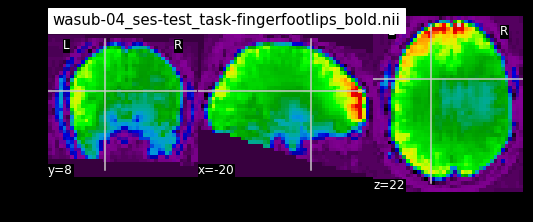

In [12]:
# Identifier of the subject
SUBJECT_ANALYSIS = SUBJECTS[3]

# Functional image of the subject
BOLD_FILE = glob.glob(os.path.join(PREPROCESS_PATH, 
                                   SUBJECT_ANALYSIS, 'normalize_func', 
                                   SUBJECT_ANALYSIS, '*fingerfootlips*.nii')).pop()

# Plot de functional image
plot_func_img(BOLD_FILE, FIGURES_OUTPUT)

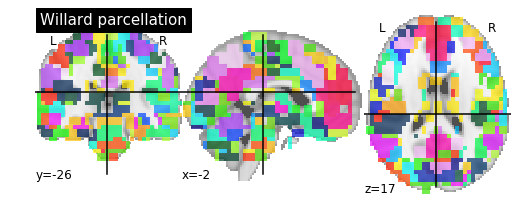

In [13]:
# Parcellation Mask for the analysis
PARCELLATION_MASK = get_willard_mask(PYHRF_OUTPUT, BOLD_FILE)

# Plot the Willard mask
plot_anatomical(PARCELLATION_MASK, FIGURES_OUTPUT);

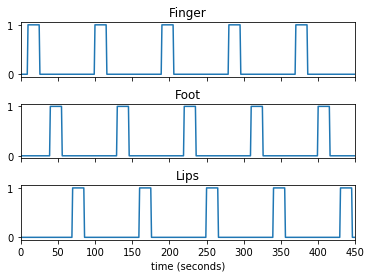

In [14]:
# Paradigm run during the acquisiton of the functional image
HEADER_PARADIGM = ['onset', 'duration', 'weight', 'trial_type']
EVENTS_FILE = glob.glob(os.path.join(dataset_path,'*fingerfootlips*.tsv')).pop()
PARADIGM_FILE = convert_to_pyhrf_csv(EVENTS_FILE, 0, HEADER_PARADIGM)

# Plot the paradigm
paradigm = plot_paradigm(PARADIGM_FILE, FIGURES_OUTPUT)

### PyHRF Parameters

Now, we play with some parameters of the underlying model of PyHRF.

In [ ]:
# Estimate the HRF
ESTIMATE_HRF = True

# Zero constraint 
ZERO_CONSTRAINT = True

# Time length of the HRF (in seconds, default: 25.0)
HRF_DURATION = TR * 10.0

# Time resolution of the HRF
DT = TR / 2.0

HRF_HYPERPRIOR = 1000 #100000

BETA = 1.0

SIGMA_H = 0.1

# Drifts type ('poly', 'cos')
DRIFT_TYPE = 'cos'  # poly

### Running PyHRF

Now, we launch PyHRF with the parameters specified before and on several processors thanks to the library `joblib`.

In [ ]:
# PyHRF command line template
command_pyhrf_template = [
    "pyhrf_jde_vem_analysis \\\n",
    "--dt {dt} \\\n",
    "--hrf-duration {hrf_len} \\\n",
    "--output {output} \\\n",
    "--beta {beta} \\\n",
    "--hrf-hyperprior {hrf_hyperprior} \\\n",
    "--sigma-h {sigma_h} \\\n",
    "{estimate_hrf} \\\n",
    "{zero_constraint} \\\n",
    "--drifts-type {drifts_type} \\\n",
    "--parallel \\\n",
    "--log-level {log_level} \\\n",
    "{tr} \\\n",
    "{parcellation_mask} \\\n",
    "{paradigm} \\\n",
    "{bold_file}"]

# Filling the command line template with the paramteres defined above
command_to_run = "".join(command_pyhrf_template).format(
    log_level='WARNING',
    estimate_hrf='--estimate-hrf' if ESTIMATE_HRF else '--no-estimate-hrf',
    zero_constraint='--zero-constraint' if ZERO_CONSTRAINT else '--no-zero-constraint',
    parcellation_mask=PARCELLATION_MASK,
    beta=BETA,
    sigma_h=SIGMA_H,
    hrf_hyperprior=HRF_HYPERPRIOR,
    drifts_type=DRIFT_TYPE,
    output=PYHRF_OUTPUT,
    hrf_len=HRF_DURATION,
    tr=TR,
    dt=DT,
    bold_file=BOLD_FILE,
    paradigm=PARADIGM_FILE)

# Run PyHRF
print('\nRunning ...\n', command_to_run, '\n')
subprocess.call(command_to_run, shell=True)
print('Done!')

## Visualization

Finally, we use the library `nilearn` to show the Posterior Probability Maps (PPMs) generated by PyHRF. Moreover, we show the Hemodynamic Response Function (HRF) for each activated parcel on the subject's brain.

In [ ]:
from pyhrf.boldsynth.hrf import getCanoHRF
from pyhrf.ndarray import xndarray
import re
from scipy.ndimage import label, sum as ndi_sum
from scipy.ndimage.morphology import generate_binary_structure


def find_ppms_maps(output_dir):
    """Find the PPM maps generated by PyHRF.
        
    Parameters
    ----------
    output_dir : str
        Path of the PyHRF output directory.

    Returns
    -------
    dict 
        Dictionary whose keys are the contrasts labels and the ppm files are the values.
        
    Examples
    --------
    >>> print(find_ppms_maps('/home/jariasal/scipy_notebook/output/114/pyhrf_output'))
    {'Foot': 'jde_vem_ppm_a_nrl_Foot.nii', 'Lips': 'jde_vem_ppm_a_nrl_Lips.nii', 'Finger': 'jde_vem_ppm_a_nrl_Finger.nii'}
    
    """
    ppm_maps = (os.path.basename(p) for p in glob.glob(os.path.join(output_dir, 'jde_vem_ppm_a_nrl*.nii')))
    pattern_name = re.compile("jde_vem_ppm_a_nrl_(.*)\.nii")

    ppm_dic = {pattern_name.match(ppm).group(1).replace('_', ' ').title(): ppm
               for ppm in ppm_maps}

    return ppm_dic


def find_activated_parcels(ppm_map, parcels_mask, ppm_threshold, cluster_size_threshold):
    """Find activated parcels for a given PPM map.

    Parameters
    ----------
    ppm_map : ~numpy.ndarray
        Posterior Probability Map data
    parcels_mask : ~numpy.ndarray
        parcellation mask data
    ppm_threshold : float
        threshold for the PPM
    cluster_size_threshold : int
        threshold for the size of the cluster of activated neurons

    Returns
    -------
    list of int
        Activated parcels
        
    Examples
    --------
    >>> from nilearn.image import load_img
    >>> parcels_img = load_img(PARCELLATION_MASK)
    >>> parcels_img_data = parcels_img.get_data()
    >>> ppm_img = load_img(os.path.join('/home/jariasal/scipy_notebook/output/114/pyhrf_output', 'jde_vem_ppm_a_nrl_Finger.nii'))
    >>> print(find_activated_parcels(ppm_img.get_data(), parcels_img_data, 0.99999, 50))
    [ 21 101 290 417 485]

    """
    ppm_map[np.isnan(ppm_map)] = 0.
    ppm_map_mask = (ppm_map >= ppm_threshold)  # binary ppm_map
    binary_structure = generate_binary_structure(3, 2)  # structuring element that defines neighborhood connections

    ppm_map_labeled, nb_labels = label(ppm_map_mask, structure=binary_structure)

    if not nb_labels:  # always select at least one cluster
        ppm_threshold = ppm_map.max() * 0.9999
        ppm_map_mask = (ppm_map >= ppm_threshold)
        ppm_map_labeled, nb_labels = label(ppm_map_mask, structure=binary_structure)
        print("ppm_threshold set to {}".format(ppm_threshold))

    # number of active voxels for each cluster
    clusters_size = ndi_sum(ppm_map_mask, ppm_map_labeled, index=np.arange(nb_labels+1))

    # clusters (labels) whose number of active voxels is greater than the threshold
    active_clusters = clusters_size >= cluster_size_threshold

    if not active_clusters.any():  # threshold for cluster size is too high
        cluster_size_threshold = np.amax(clusters_size)
        active_clusters = clusters_size >= cluster_size_threshold
        print("cluster_size_threshold set to {}".format(cluster_size_threshold))

    # voxels belonging the clusters whose number of active voxels is greater than the threshold
    active_clusters_mask = active_clusters[ppm_map_labeled]
    active_parcels = np.unique(parcels_mask[active_clusters_mask])

    return active_parcels

### Visualization Parameters

We can set some thresholds to show only the most significant voxels and parcels.

In [ ]:
# PPM threshold
PPM_THRESHOLD = 0.88

# Cluster size threshold
CLUSTER_SIZE_THRESHOLD = 50  # 50 voxels correspond to a volume of 400 mm3 when the voxel size is 2 mm-isotropic.

# Posterior Probability Maps (PPM)
ppms_maps = find_ppms_maps(PYHRF_OUTPUT)

# PPM to be shown
ppm_name = 'Finger'
ppm_nii = ppms_maps[ppm_name]

# Cuts in z-direction axial 
cut_coords = range(55, 66, 5)

### Generate Figures

Finally, we create a figure with three axes to show the PPMs, the parcellation and the HRF for each active parcel.

In [ ]:
# Figure configuration
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

fig = plt.figure(figsize=(20, 9))
gs = gridspec.GridSpec(2, 2);

# Parcellation image
parcels_img = load_img(PARCELLATION_MASK)
parcels_img_data = np.array(parcels_img.get_data())

# Anatomical image
ANAT_IMAGE = glob.glob(os.path.join(PREPROCESS_PATH, SUBJECT_ANALYSIS, 'normalize_anat', SUBJECT_ANALYSIS, 'w*.nii')).pop()
anat_img = load_img(ANAT_IMAGE)

# Estimated HRF
hrf_s = xndarray.load(os.path.join(PYHRF_OUTPUT, 'jde_vem_hrf.nii'))
time_axis, canonical_hrf = getCanoHRF(duration=HRF_DURATION, dt=DT)

# Plot Canonical HRF
ax_hrf = plt.subplot(gs[:, 1])
ax_hrf.plot(time_axis, canonical_hrf, ":", label="Canonical")
ax_hrf.set_xlim([0,np.max(time_axis)])

# Plot PPM
ax_ppm = plt.subplot(gs[0, 0])
ppm_img = load_img(os.path.join(PYHRF_OUTPUT, ppm_nii))
plot_stat_map(stat_map_img=ppm_img, threshold=PPM_THRESHOLD, colorbar=False,
              cut_coords=cut_coords, display_mode='z', draw_cross=False,
              title=ppm_name, figure=fig, axes=ax_ppm, cmap=plt.cm.autumn)

# Plotting estimated HRF per Parcel
active_parcels = find_activated_parcels(ppm_img.get_data(), parcels_img_data,
                                        PPM_THRESHOLD, CLUSTER_SIZE_THRESHOLD)

hrf_mean = np.zeros(hrf_s.data.shape[1])
parcels_data = np.zeros_like(parcels_img_data)
for color_nb, parcel_id in enumerate(active_parcels):
    sub_cuboid = hrf_s.sub_cuboid(ROI=parcel_id).data
    hrf_mean += sub_cuboid
    parcels_data[parcels_img_data == parcel_id] = color_nb + 1

    ax_hrf.plot(time_axis, sub_cuboid, "--", color=plt.cm.gist_ncar(float(color_nb) / len(active_parcels)))   


hrf_mean /= len(active_parcels)
ax_hrf.plot(time_axis, hrf_mean, label=ppm_name, color="k", linewidth=2)

# Plotting parcels
hrf_parcels_img = nibabel.Nifti1Image(parcels_data, parcels_img.affine, parcels_img.get_header())
ax_rois = plt.subplot(gs[1, 0])
plot_roi(roi_img=hrf_parcels_img,
         cut_coords=cut_coords, display_mode='z', draw_cross=False, # Generate UserWarning
         title="HRF parcels", figure=fig, axes=ax_rois)

# Legend
ax_hrf.legend(fontsize=20);

# save figure
plt.savefig(os.path.join(FIGURES_OUTPUT, '%s.png' % ppm_name));